In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import gc

import random
from scipy.interpolate import interp1d
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Processing the training data

## 1-1. generating the 2d projected .png from 3d .swc

In [5]:
# set train data path
path_train     = '/kaggle/input/phys591000-2022-final-project-ii/fc_train_data/fc_train_data'
df_train = pd.read_csv('/kaggle/input/phys591000-2022-final-project-ii/fc_train_data/fc_train_data/fc_training_list.csv')

label_train = np.array(df_train['label'])
id_train    = np.array(df_train['id'])

# # separate the id with label==1 and label==0
# id_train_type1 = id_train[label_train==1]
# id_train_type0 = id_train[label_train==0]

# select         = random.sample(range(1207),293)
# id_train_type1 = id_train_type1[select]

# training data id list and label list
# id_train_list    = np.hstack((id_train_type1,id_train_type0))
# label_train_list = np.hstack((np.ones(len(id_train_type1)), np.zeros(len(id_train_type0))))

In [6]:
# shift the .swc location into "int" frame3d and record each position(x,y,z)

# loading .swc file as numpy array
# when axis=1 value==1 -> R
#             value==2 -> position of x
#             value==3 -> position of x
#             value==4 -> position of x

# structure of dict_swc : {dict_swc['id1']['r'],
#                                         ['x'],
#                                         ['y'],
#                                         ['z'],
#                          dict_swc['id2']['r'],
#                                         ['x'],
#                                         ['y'],
#                                         ['z'],
#                          dict_swc['id3'],
#                          ...
#                          }

import pickle

dict_swc= {}
for i in range(len(id_train)):
    swc_train = np.loadtxt(f"{path_train}/swc/{id_train[i]}.swc")
    
    x = swc_train[:,2]
    y = swc_train[:,3]
    z = swc_train[:,4]
    
    if len(swc_train[:,1])<2000:
        intersize = int((2000/len(swc_train[:,1]))+1)
        interval_axis = np.linspace(1, len(swc_train[:,1]), len(swc_train[:,1]))
        interpol_axis = np.linspace(1, len(swc_train[:,1]), intersize*len(swc_train[:,1]))
        fx = interp1d(interval_axis, swc_train[:,2], kind='cubic')
        fy = interp1d(interval_axis, swc_train[:,3], kind='cubic')
        fz = interp1d(interval_axis, swc_train[:,4], kind='cubic')

        x = fx(interpol_axis)
        y = fy(interpol_axis)
        z = fz(interpol_axis)
        
    dict_swc[id_train[i]] = {}
    dict_swc[id_train[i]]['r'] = swc_train[:,1]
    dict_swc[id_train[i]]['x'] = x
    dict_swc[id_train[i]]['y'] = y
    dict_swc[id_train[i]]['z'] = z

    
with open(f"/kaggle/working/dict_swc.pickle", "wb") as f:
    pickle.dump(dict_swc,f)
    
del dict_swc, swc_train, interval_axis, interpol_axis

In [8]:
# Doing projected image to x,y,z 

# using pickcle to load the .scw information
import pickle
dict_swc = pickle.load(open("/kaggle/working/dict_swc.pickle", "rb"))

import imageio

axis_range = np.linspace(-524, 525, 1050)

i=1

for idname in id_train:
    
    frame3d    = np.zeros((1050,1050,1050), dtype=np.int8)
    
    # check folder exist or not
    if not os.path.isdir(f"/kaggle/working/train_3d/"):
        os.makedirs(f"/kaggle/working/train_3d/")
    savepath = f"/kaggle/working/train_3d/"

    if i%25==0:
        print(f"Run No.{i}")
    i = i+1
    
    x_list_raw = dict_swc[idname]['x']
    y_list_raw = dict_swc[idname]['y']
    z_list_raw = dict_swc[idname]['z']
    
    x_interval = np.max(x_list_raw)-np.min(x_list_raw)
    y_interval = np.max(y_list_raw)-np.min(y_list_raw)
    z_interval = np.max(z_list_raw)-np.min(z_list_raw)
    
    # 放大倍率
    for resize in [5., 4., 3., 2.]:
        if (x_interval<(1050./resize)) & (y_interval<(1050./resize)) & (z_interval<(1050./resize)):

            x_mid = (np.max(x_list_raw)+np.min(x_list_raw))/2.
            y_mid = (np.max(y_list_raw)+np.min(y_list_raw))/2.
            z_mid = (np.max(z_list_raw)+np.min(z_list_raw))/2.

            # shift the point in the middle of the image
            # +
            # enlarge its size to "resize" times
            x_list = (x_list_raw - x_mid)*resize
            y_list = (y_list_raw - y_mid)*resize
            z_list = (z_list_raw - z_mid)*resize
            
            x_list = np.ceil(x_list)
            y_list = np.ceil(y_list)
            z_list = np.ceil(z_list)
            break
             
        else:
            x_list = np.ceil(x_list_raw)
            y_list = np.ceil(y_list_raw)
            z_list = np.ceil(z_list_raw)
        
    index = len(dict_swc[idname]['x'])-1    
    while(index):
        axis_index0 = np.where(axis_range == x_list[index])[0][0]
        axis_index1 = np.where(axis_range == y_list[index])[0][0]
        axis_index2 = np.where(axis_range == z_list[index])[0][0]
#         frame3d[axis_index0  , axis_index1  , axis_index2] = 1  # original point
        
        if axis_index0==1049 or axis_index1==1049 or axis_index2==1049:
            index = index -1
            continue
        if axis_index0==0 or axis_index0==0 or axis_index0==0:
            index = index -1
            continue
            
        # z=0 plane
        frame3d[axis_index0+1, axis_index1+1, axis_index2] = 1
        frame3d[axis_index0+1, axis_index1  , axis_index2] = 1
        frame3d[axis_index0+1, axis_index1-1, axis_index2] = 1
        frame3d[axis_index0  , axis_index1+1, axis_index2] = 1
        frame3d[axis_index0  , axis_index1  , axis_index2] = 1  # (0,0,0)original point
        frame3d[axis_index0  , axis_index1-1, axis_index2] = 1
        frame3d[axis_index0-1, axis_index1+1, axis_index2] = 1
        frame3d[axis_index0-1, axis_index1  , axis_index2] = 1
        frame3d[axis_index0-1, axis_index1-1, axis_index2] = 1
        
        # z=+1 plane
        frame3d[axis_index0+1, axis_index1+1, axis_index2+1] = 1
        frame3d[axis_index0+1, axis_index1  , axis_index2+1] = 1
        frame3d[axis_index0+1, axis_index1-1, axis_index2+1] = 1
        frame3d[axis_index0  , axis_index1+1, axis_index2+1] = 1
        frame3d[axis_index0  , axis_index1  , axis_index2+1] = 1  # (0,0,1)
        frame3d[axis_index0  , axis_index1-1, axis_index2+1] = 1
        frame3d[axis_index0-1, axis_index1+1, axis_index2+1] = 1
        frame3d[axis_index0-1, axis_index1  , axis_index2+1] = 1
        frame3d[axis_index0-1, axis_index1-1, axis_index2+1] = 1
        
        # z=-1 plane
        frame3d[axis_index0+1, axis_index1+1, axis_index2-1] = 1
        frame3d[axis_index0+1, axis_index1  , axis_index2-1] = 1
        frame3d[axis_index0+1, axis_index1-1, axis_index2-1] = 1
        frame3d[axis_index0  , axis_index1+1, axis_index2-1] = 1
        frame3d[axis_index0  , axis_index1  , axis_index2-1] = 1  # (0,0,-1)
        frame3d[axis_index0  , axis_index1-1, axis_index2-1] = 1
        frame3d[axis_index0-1, axis_index1+1, axis_index2-1] = 1
        frame3d[axis_index0-1, axis_index1  , axis_index2-1] = 1
        frame3d[axis_index0-1, axis_index1-1, axis_index2-1] = 1
        
        index = index -1
        
    xy_plane = np.sum(frame3d, axis=2, dtype=np.int8)
    yz_plane = np.sum(frame3d, axis=0, dtype=np.int8)
    xz_plane = np.sum(frame3d, axis=1, dtype=np.int8)

    xy_plane[xy_plane!=0]=1
    yz_plane[yz_plane!=0]=1
    xz_plane[xz_plane!=0]=1
    
    imageio.imwrite(f"{savepath}/{idname}_xyplane.png", xy_plane)
    imageio.imwrite(f"{savepath}/{idname}_yzplane.png", yz_plane)
    imageio.imwrite(f"{savepath}/{idname}_xzplane.png", xz_plane)
    
del dict_swc, x_list, y_list, z_list, frame3d, axis_range
del x_interval, y_interval, z_interval
del x_list_raw, y_list_raw, z_list_raw
del axis_index0, axis_index1, axis_index2
del xy_plane, yz_plane, xz_plane

Run No.25
Run No.50
Run No.75
Run No.100
Run No.125
Run No.150
Run No.175
Run No.200
Run No.225
Run No.250
Run No.275
Run No.300
Run No.325
Run No.350
Run No.375
Run No.400
Run No.425
Run No.450
Run No.475
Run No.500
Run No.525
Run No.550
Run No.575
Run No.600
Run No.625
Run No.650
Run No.675
Run No.700
Run No.725
Run No.750
Run No.775
Run No.800
Run No.825
Run No.850
Run No.875
Run No.900
Run No.925
Run No.950
Run No.975
Run No.1000
Run No.1025
Run No.1050
Run No.1075
Run No.1100
Run No.1125
Run No.1150
Run No.1175
Run No.1200
Run No.1225
Run No.1250
Run No.1275
Run No.1300
Run No.1325
Run No.1350
Run No.1375
Run No.1400
Run No.1425
Run No.1450
Run No.1475
Run No.1500


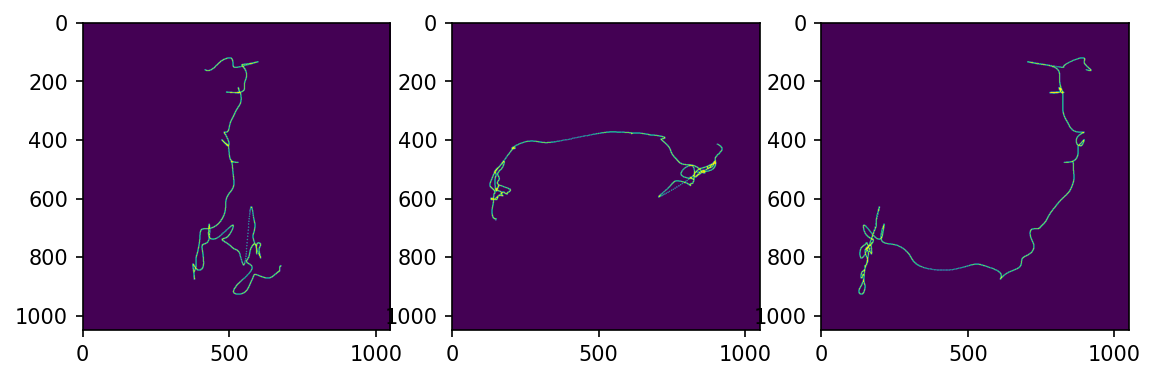

In [4]:
# Checking the projected plane image (with our code)
import matplotlib.pyplot as plt

idname = id_train[400]
savepath = f"./train_3d/"

fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplot(1,3,1)
plt.imshow(plt.imread(f"{savepath}/{idname}_xyplane.png"))

plt.subplot(1,3,2)
plt.imshow(plt.imread(f"{savepath}/{idname}_yzplane.png"))

plt.subplot(1,3,3)
plt.imshow(plt.imread(f"{savepath}/{idname}_xzplane.png"))

plt.show()

## 2. Processing the testing data

### 2-1. generating the 2d projected .png from 3d .swc (same as 1-1)

In [9]:
import os

path_test = '/kaggle/input/phys591000-2022-final-project-ii/fc_test_data/fc_test_data/'
id_test_list_swc = os.listdir(path_test+"swc")

import re
id_test_list_swc_re = []
for i in range(len(id_test_list_swc)):
    id_test_list_swc_re.append(re.sub('\.swc$', '', id_test_list_swc[i]))

dict_swc_test= {}
for i in range(len(id_test_list_swc)):
    swc_test = np.loadtxt(f"{path_test}/swc/{id_test_list_swc[i]}")
    
    x = swc_test[:,2]
    y = swc_test[:,3]
    z = swc_test[:,4]
    
    if len(swc_test[:,1])<2000:
        intersize = int((2000/len(swc_test[:,1]))+1)
        interval_axis = np.linspace(1, len(swc_test[:,1]), len(swc_test[:,1]))
        interpol_axis = np.linspace(1, len(swc_test[:,1]), intersize*len(swc_test[:,1]))
        fx = interp1d(interval_axis, swc_test[:,2], kind='cubic')
        fy = interp1d(interval_axis, swc_test[:,3], kind='cubic')
        fz = interp1d(interval_axis, swc_test[:,4], kind='cubic')
        
        x = fx(interpol_axis)
        y = fy(interpol_axis)
        z = fz(interpol_axis)
    
    dict_swc_test[id_test_list_swc_re[i]] = {}
    dict_swc_test[id_test_list_swc_re[i]]['r'] = swc_test[:,1]
    dict_swc_test[id_test_list_swc_re[i]]['x'] = x
    dict_swc_test[id_test_list_swc_re[i]]['y'] = y
    dict_swc_test[id_test_list_swc_re[i]]['z'] = z

    
with open(f"/kaggle/working/dict_swc_test.pickle", "wb") as f:
    pickle.dump(dict_swc_test,f)
    
del dict_swc_test, swc_test, interval_axis, interpol_axis

In [10]:
# using pickcle to save the .scw information in 1 file
dict_swc_test = pickle.load(open("/kaggle/working/dict_swc_test.pickle", "rb"))

axis_range = np.linspace(-524, 525, 1050)

i=1
for idname in id_test_list_swc_re:
    
    frame3d    = np.zeros((1050,1050,1050), dtype=np.int8)
    
    # check folder exist or not
    if not os.path.isdir(f"/kaggle/working/test_3d/"):
        os.makedirs(f"/kaggle/working/test_3d/")
    savepath = f"/kaggle/working/test_3d/"

    if i%50==0:
        print(f"Run No.{i}")
    i = i+1
    
    x_list_raw_test = dict_swc_test[idname]['x']
    y_list_raw_test = dict_swc_test[idname]['y']
    z_list_raw_test = dict_swc_test[idname]['z']
    
    x_interval_test = np.max(x_list_raw_test)-np.min(x_list_raw_test)
    y_interval_test = np.max(y_list_raw_test)-np.min(y_list_raw_test)
    z_interval_test = np.max(z_list_raw_test)-np.min(z_list_raw_test)
    
    # 放大倍率
    for resize in [5., 4., 3., 2.]:
        if (x_interval_test<(1050./resize)) & (y_interval_test<(1050./resize)) & (z_interval_test<(1050./resize)):

            x_mid_test = (np.max(x_list_raw_test)+np.min(x_list_raw_test))/2.
            y_mid_test = (np.max(y_list_raw_test)+np.min(y_list_raw_test))/2.
            z_mid_test = (np.max(z_list_raw_test)+np.min(z_list_raw_test))/2.

            # shift the point in the middle of the image
            # +
            # enlarge its size to "resize" times
            x_list_test = (x_list_raw_test - x_mid_test)*resize
            y_list_test = (y_list_raw_test - y_mid_test)*resize
            z_list_test = (z_list_raw_test - z_mid_test)*resize
            
            x_list_test = np.ceil(x_list_test)
            y_list_test = np.ceil(y_list_test)
            z_list_test = np.ceil(z_list_test)
            break
             
        else:
            x_list_test = np.ceil(x_list_raw_test)
            y_list_test = np.ceil(y_list_raw_test)
            z_list_test = np.ceil(z_list_raw_test)
            
            
    index = len(dict_swc_test[idname]['x'])-1
    while(index):
        axis_index0 = np.where(axis_range == x_list_test[index])[0][0]
        axis_index1 = np.where(axis_range == y_list_test[index])[0][0]
        axis_index2 = np.where(axis_range == z_list_test[index])[0][0]
#         frame3d[axis_index0, axis_index1, axis_index2] = 1

        if axis_index0==1049 or axis_index1==1049 or axis_index2==1049:
            index = index -1
            continue
        if axis_index0==0 or axis_index0==0 or axis_index0==0:
            index = index -1
            continue

        # z=0 plane
        frame3d[axis_index0+1, axis_index1+1, axis_index2] = 1
        frame3d[axis_index0+1, axis_index1  , axis_index2] = 1
        frame3d[axis_index0+1, axis_index1-1, axis_index2] = 1
        frame3d[axis_index0  , axis_index1+1, axis_index2] = 1
        frame3d[axis_index0  , axis_index1  , axis_index2] = 1  # (0,0,0)original point
        frame3d[axis_index0  , axis_index1-1, axis_index2] = 1
        frame3d[axis_index0-1, axis_index1+1, axis_index2] = 1
        frame3d[axis_index0-1, axis_index1  , axis_index2] = 1
        frame3d[axis_index0-1, axis_index1-1, axis_index2] = 1
        
        # z=+1 plane
        frame3d[axis_index0+1, axis_index1+1, axis_index2+1] = 1
        frame3d[axis_index0+1, axis_index1  , axis_index2+1] = 1
        frame3d[axis_index0+1, axis_index1-1, axis_index2+1] = 1
        frame3d[axis_index0  , axis_index1+1, axis_index2+1] = 1
        frame3d[axis_index0  , axis_index1  , axis_index2+1] = 1  # (0,0,1)
        frame3d[axis_index0  , axis_index1-1, axis_index2+1] = 1
        frame3d[axis_index0-1, axis_index1+1, axis_index2+1] = 1
        frame3d[axis_index0-1, axis_index1  , axis_index2+1] = 1
        frame3d[axis_index0-1, axis_index1-1, axis_index2+1] = 1
        
        # z=-1 plane
        frame3d[axis_index0+1, axis_index1+1, axis_index2-1] = 1
        frame3d[axis_index0+1, axis_index1  , axis_index2-1] = 1
        frame3d[axis_index0+1, axis_index1-1, axis_index2-1] = 1
        frame3d[axis_index0  , axis_index1+1, axis_index2-1] = 1
        frame3d[axis_index0  , axis_index1  , axis_index2-1] = 1  # (0,0,-1)
        frame3d[axis_index0  , axis_index1-1, axis_index2-1] = 1
        frame3d[axis_index0-1, axis_index1+1, axis_index2-1] = 1
        frame3d[axis_index0-1, axis_index1  , axis_index2-1] = 1
        frame3d[axis_index0-1, axis_index1-1, axis_index2-1] = 1


        index = index -1

    xy_plane = np.sum(frame3d, axis=2, dtype=np.int8)
    yz_plane = np.sum(frame3d, axis=0, dtype=np.int8)
    xz_plane = np.sum(frame3d, axis=1, dtype=np.int8)

    xy_plane[xy_plane!=0]=1.
    yz_plane[yz_plane!=0]=1.
    xz_plane[xz_plane!=0]=1.
    
    imageio.imwrite(f"{savepath}/{idname}_xyplane.png", xy_plane)
    imageio.imwrite(f"{savepath}/{idname}_yzplane.png", yz_plane)
    imageio.imwrite(f"{savepath}/{idname}_xzplane.png", xz_plane)
    
del dict_swc_test, x_list_test, y_list_test, z_list_test, axis_range
del x_interval_test, y_interval_test, z_interval_test
del x_list_raw_test, y_list_raw_test, z_list_raw_test, frame3d
del axis_index0, axis_index1, axis_index2
del xy_plane, yz_plane, xz_plane
del id_test_list_swc_re

Run No.50
Run No.100
Run No.150
Run No.200
Run No.250
Run No.300
Run No.350
Run No.400
Run No.450


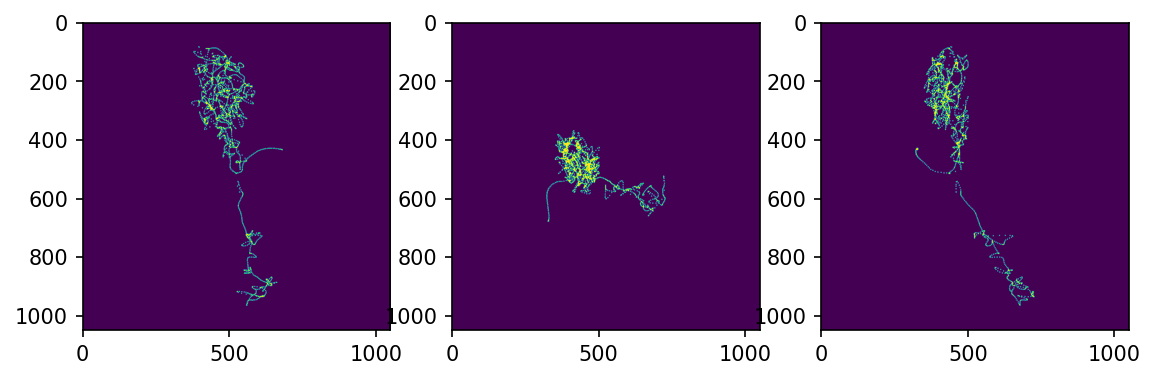

In [14]:
# Checking the projected plane image (with our code)
import matplotlib.pyplot as plt

path_test = '/kaggle/input/phys591000-2022-final-project-ii/fc_test_data/fc_test_data/'
id_test_list_swc = os.listdir(path_test+"swc")

import re
id_test_list_swc_re = []
for i in range(len(id_test_list_swc)):
    id_test_list_swc_re.append(re.sub('\.swc$', '', id_test_list_swc[i]))

idname = id_test_list_swc_re[10]
savepath = f"./test_3d/"

fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplot(1,3,1)
plt.imshow(plt.imread(f"{savepath}/{idname}_xyplane.png"))

plt.subplot(1,3,2)
plt.imshow(plt.imread(f"{savepath}/{idname}_yzplane.png"))

plt.subplot(1,3,3)
plt.imshow(plt.imread(f"{savepath}/{idname}_xzplane.png"))

plt.show()